In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

path = "/home/yaning/Documents/"
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=float('inf'))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open(path + "fire_data_10p_8f_non_zero.pkl", "rb") as f:
    fire_data = pickle.load(f)

In [4]:
fire_data = torch.tensor(fire_data, device=device).float()

In [5]:
fire_data.shape

torch.Size([100, 10, 10, 8, 6000])

In [6]:
# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

gMax_AMPA = 0.0072
gMax_NMDA = 0.0012
gMax_GABA = 0.004

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 140

mg = 0.01

threshold = -50 + 70
current_threshold = -200


# below parameters are all guesses
u_se = torch.tensor([0.9, 0.9, 0.9], device=device)

tau_rec = torch.tensor([5, 12, 12], device=device)
tau_pre = torch.tensor([113, 113, 113], device=device)
# tau_post = torch.tensor([20, 10, 10], device=device)
tau_decay = torch.tensor([10, 15, 15], device=device)
tau_rise = torch.tensor([8, 7, 7], device=device)

learning_rate = 0.7

# generate the exponential decrease with time gap values
gaps = torch.arange(400, 0, -1, device=device).unsqueeze(0).expand(3,400)
temp_tau_pre = tau_pre.unsqueeze(-1)
weight_values_matrix = torch.exp(-gaps/temp_tau_pre)

for _ in range(5):
    weight_values_matrix = weight_values_matrix.unsqueeze(1)

In [7]:
def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states


In [8]:
def broadcast_params(param, target):
    new_shape = (3,) + (1,)*(target.dim()-1)
    param = param.view(new_shape)
    param = param.expand_as(target)
    return param

def broadcast_mp(mp, connection_matrix):
    num_missing_dim = connection_matrix.dim() - mp.dim()
    mp = mp.view(*([1]*num_missing_dim), *mp.shape)
    mp = mp.expand_as(connection_matrix)
    return mp


def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# # deri as deriviation 
# def e_deri(e, on_off):
#     return (1-e)/tau_rec[None,:,None,None] - u_se[None,:,None,None]*on_off

# def g_decay_deri(g_decay, w, e, on_off):
#     return -g_decay/tau_decay[None,:,None,None] + w*e*on_off

# def g_rise_deri(g_rise, w, e, on_off):
#     return -g_rise/tau_rise[None,:,None,None] + w*e*on_off

# deri as deriviation 
def e_deri(e, on_off):
    tau_rec_broad = broadcast_params(tau_rec, e)
    u_se_broad = broadcast_params(u_se, e)
    return (1-e)/tau_rec_broad - u_se_broad*on_off

def g_decay_deri(g_decay, w, e, on_off):
    tau_decay_broad = broadcast_params(tau_decay, e)
    return -g_decay/tau_decay_broad + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    tau_rise_broad = broadcast_params(tau_rise, e)
    return -g_rise/tau_rise_broad + w*e*on_off

In [9]:
# def update_gPs(e, g_decay, g_rise, activeness, w, deltaTms=0.05):
#     # update e
#     e = runge_kutta(e_deri, e, deltaTms, activeness)

#     # update g_decay and g_rise
#     # deltaTms * 10 is not good, when try to find the right params need to delete this
#     g_decay = runge_kutta(g_decay_deri, g_decay, deltaTms*10, w, e, activeness)
#     g_rise = runge_kutta(g_rise_deri, g_rise, deltaTms*10, w, e, activeness)

#     gP = g_rise - g_decay

#     return e, g_decay, g_rise, gP

def update_gPs(es, ws, g_decays, g_rises, activenesses, deltaTms=0.05):
    # update e
    cycle = len(es)
    new_es = []
    new_g_decays = []
    new_g_rises = []
    gPs = []
    
    for i in range(cycle):
        # print(es[i].shape)
        e = runge_kutta(e_deri, es[i], deltaTms, activenesses[i])

        

        # update g_decay and g_rise
        # deltaTms * 10 is not good, when try to find the right params need to delete this
        g_decay = runge_kutta(g_decay_deri, g_decays[i], deltaTms*10, ws[i], e, activenesses[i])
        g_rise = runge_kutta(g_rise_deri, g_rises[i], deltaTms*10, ws[i], e, activenesses[i])

        gP = g_rise - g_decay

        new_es.append(e)
        new_g_decays.append(g_decay)
        new_g_rises.append(g_rise)
        gPs.append(gP)

    return new_es, new_g_decays, new_g_rises, gPs

In [10]:
# the last param is how many synapses it needs to have 
def initialise(*args):
    d = args[0]

    # cells, states, mp are fine with only individual cells
    cells = torch.zeros((d, d), device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # the synapses properties are not individual cell but 
    # shape as the connections

    es = []
    ws = []
    g_decays = []
    g_rises = []

    for arg in args[1:]:
        # 3 is for the three types of receptors 
        muster = torch.zeros((3,*arg.shape), device=device)

        e = muster.clone()
        e.fill_(1)
        es.append(e)

        # Q: if different receptors in the same synapse have same/different weights
        w = torch.rand_like(muster)
        ws.append(w)

        g_decay = muster.clone()
        g_decay.fill_(1)
        g_decays.append(g_decay)

        g_rise = muster.clone()
        g_rise.fill_(1)
        g_rises.append(g_rise)



        # # weight randomised at initial (0-1)
        # w = w.unsqueeze(1).expand(-1,3,-1,-1)



    return cells, states, mp, es, ws, g_decays, g_rises

In [11]:
# initialise everything

pixel_num = 10
feature_num = 8
E_num = 20
I_num = 4
Out_num = 5


#-----------connection matrices-------------
In_con_E = torch.zeros(pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E.fill_(1.)

# the later two E_nums are the one sending out the connections/the center
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 10
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)
E_con_E = E_con_E.permute(2, 3, 0, 1)

# E to I connection matrix (p=0.1)
E_con_I = torch.zeros(E_num, E_num, I_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1

# I to E connection matrix (p=0.024)
I_con_E = torch.zeros(I_num, I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1

# I to I self connection (p=0.1)
I_con_I = torch.zeros(I_num, I_num, I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1

# E to Out connection
E_con_Out = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 10
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Out[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)



#----------E---------------------
E_cells, E_states, E_mp, E_es, E_ws, E_g_decays, E_g_rises = initialise(E_num, In_con_E, E_con_E, I_con_E)
# E_e_In, E_e_E, E_e_I = E_es
# E_w_In, E_w_E, E_w_I = E_ws
# E_g_decay_In, E_g_decay_E, E_g_decay_I = E_g_decays
# E_g_rise_In, E_g_rise_E, E_g_rise_I = E_g_rises


#----------I-----------------
I_cells, I_states, I_mp, I_es, I_ws, I_g_decays, I_g_rises = initialise(I_num, E_con_I, I_con_I)
# I_e_E, I_e_I = I_es
# I_w_E, I_w_I = I_ws
# I_g_decay_E, I_g_decay_I = I_g_decays
# I_g_rise_E, I_g_rise_I = I_g_rises

#-----------Output-------------
Out_cells, Out_states, Out_mp, Out_es, Out_ws, Out_g_decays, Out_g_rises = initialise(Out_num, E_con_Out)
# [Out_e_E] = Out_es
# [Out_w_E] = Out_ws
# [Out_g_decay_E] = Out_g_decays
# [Out_g_rise_E] = Out_g_rises



In [12]:
one_pic = fire_data[25, :, :, :]

In [13]:
def activeness_modif(activeness, *args):
    # select the receptor types 
    temp = torch.zeros((3,*activeness.shape), device=device)
    for arg in args:
        temp[arg] = activeness
    activeness = temp
    return activeness

def check_fire(mp):
    activeness = (mp > threshold).float()
    return activeness

# def update_I_E(gP, mp, activeness, states, w):
#     # generate currents based on gPs
#     AMPA_currents = (gMax_AMPA*gP[:,0,...]*(mp-rE_AMPA)*activeness[:,0,...]).sum(dim=0)
#     NMDA_currents = (gMax_NMDA*gP[:,1,...]*(1/1+mg*torch.exp(-0.062*mp)/3.57)*(mp-rE_NMDA)*activeness[:,1,...]).sum(dim=0)
#     GABA_currents = (gMax_GABA*gP[:,2,...]*(mp-rE_GABA)*(-1)*activeness[:,2,...]).sum(dim=0)

#     Ireceptors = AMPA_currents + NMDA_currents + GABA_currents
#     Ireceptors[Ireceptors >= 0] = 0.0

#     overflow_neurons = (Ireceptors <= current_threshold).float()

#     scaled_AMPA_NMDA = w[:,:2,:,:]*overflow_neurons*0.7
#     scaled_GABA = w[:,2:3,:,:]*overflow_neurons*1.3

#     w = torch.cat([scaled_AMPA_NMDA, scaled_GABA], dim=1)

    
#     sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
#     potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
#     leaky_currents = gMax_leaky*(mp-rE_leaky)

#     total_c = - sodium_currents - potassium_currents - leaky_currents - Ireceptors
#     total_c = total_c.sum(dim=0)
#     mp = mp + deltaTms*total_c/Cm

#     return mp, w

def update_I_E(gPs, mp, states, ws):

    # generate currents based on gPs
    cycle = len(gPs)
    muster = torch.zeros_like(mp)
    AMPA_currents = muster.clone()
    NMDA_currents = muster.clone()
    GABA_currents = muster.clone()
    
    for i in range(cycle):
        temp_mp = broadcast_mp(mp, gPs[i])

        AMPA_currents += (gMax_AMPA*gPs[i][0,...]*(temp_mp-rE_AMPA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        # if (temp_mp-rE_AMPA).all() > 0:
        #     print("nooo")
        NMDA_currents += (gMax_NMDA*gPs[i][1,...]*(1/1+mg*torch.exp(-0.062*temp_mp)/3.57)*(temp_mp-rE_NMDA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        GABA_currents += (gMax_GABA*gPs[i][2,...]*(temp_mp-rE_GABA)*(-1)).sum(dim=tuple(range(temp_mp.ndim - 2)))

    Ireceptors = AMPA_currents + NMDA_currents + GABA_currents

    Ireceptors[Ireceptors >= 0] = 0.0

    # print(Ireceptors)

    overflow_neurons = (Ireceptors <= current_threshold).float()

    for i in range(cycle):
        w = ws[i]
        scaled_AMPA_NMDA = w[:2,...]*overflow_neurons*0.7
        scaled_GABA = w[2:3,...]*overflow_neurons*1.3

        ws[i] = torch.cat([scaled_AMPA_NMDA, scaled_GABA], dim=0)

    
    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)

    total_c = - sodium_currents - potassium_currents - leaky_currents - Ireceptors
    total_c = total_c.sum(dim=0)
    mp = mp + deltaTms*total_c/Cm

    return mp, ws


In [ ]:
In_fires = one_pic
E_fires = torch.empty((pointCount, E_num, E_num), device=device)
I_fires = torch.empty((pointCount, I_num, I_num), device=device)
Out_fires = torch.empty((pointCount, Out_num, Out_num), device=device)

# In_fires_times = 

for t in tqdm(range(pointCount)):
    # check mp and which fires then change connected layer activeness
    # Input to E
    In_fire = one_pic[:, :, :, t]
    # shape like the connection matrix 
    E_activeness_In = In_fire.unsqueeze(-1).unsqueeze(-1)*In_con_E
    # only AMPA
    E_activeness_In = activeness_modif(E_activeness_In, 0)

    
    E_fire = check_fire(E_mp)
    E_fires[t] = E_fire
    # E to I
    I_activeness_E = E_fire.unsqueeze(-1).unsqueeze(-1)*E_con_I
    I_activeness_E = activeness_modif(I_activeness_E, 0, 1)

    # E to E (this einsum is getting ij instead of xy)
    E_activeness_E = E_fire.unsqueeze(-1).unsqueeze(-1)*E_con_E
    E_activeness_E = activeness_modif(E_activeness_E, 0, 1)

    # E to Out
    Out_activeness_E = E_fire.unsqueeze(-1).unsqueeze(-1)*E_con_Out
    Out_activeness_E = activeness_modif(Out_activeness_E, 0)

    I_fire = check_fire(I_mp)
    I_fires[t] = I_fire
    # I to E
    E_activeness_I = I_fire.unsqueeze(-1).unsqueeze(-1)*I_con_E
    E_activeness_I = activeness_modif(E_activeness_I, 2)

    # I to I
    I_activeness_I = I_fire.unsqueeze(-1).unsqueeze(-1)*I_con_I
    I_activeness_I = activeness_modif(I_activeness_I, 2)

    # # cannot stack different shapes 
    E_activenesses = [E_activeness_In, E_activeness_E, E_activeness_I]

    I_activenesses = [I_activeness_E, I_activeness_I]

    Out_activenesses = [Out_activeness_E]
    
    Out_fire = check_fire(Out_mp)
    Out_fires[t] = Out_fire

    # -----------------update gPs based on activeness--------------------------------
    # update them by each layer connection, cannot do it at the same time because
    # the shapes are different 
    E_states = update_states(E_mp, E_states)
    E_es, E_g_decays, E_g_rises, E_gPs = update_gPs(E_es, E_ws, E_g_decays, E_g_rises, E_activenesses)


    I_states = update_states(I_mp, I_states)
    I_es, I_g_decays, I_g_rises, I_gPs = update_gPs(I_es, I_ws, I_g_decays, I_g_rises, I_activenesses)


    Out_states = update_states(Out_mp, Out_states)
    Out_es, Out_g_decays, Out_g_rises, Out_gPs = update_gPs(Out_es, Out_ws, Out_g_decays, Out_g_rises, Out_activenesses)



    # ------------------generate currents and voltages based on gPs-------------------------------
    E_mp, E_ws = update_I_E(E_gPs, E_mp, E_states, E_ws)

    I_mp, I_ws = update_I_E(I_gPs, I_mp, I_states, I_ws)

    Out_mp, Out_ws = update_I_E(Out_gPs, Out_mp, Out_states, Out_ws)

    
    # -------------------------update weights----------------------------------
    # only In to E
    # get the matrix of needed to change weight from the cons (Q: including the current time step?)
    # take only the 400 time step before, equals to 20ms, which is the learning period in the paper
    # for now update after 400 time steps 
    if t >= 400:
        past_pre_fires = In_fires[:,:,:,t-399:t+1]

        # move the t step 3rd dimension to the last
        # interaction = interaction.permute(0, 1, 2, 4, 5, 3)

        for i in range(400):
            interaction = torch.einsum('ijk,ab->ijkab', past_pre_fires[...,i], E_fire)
            # print(interaction.shape)
            # print(weight_values_matrix[...,i].shape)
            d_ws += interaction*weight_values_matrix[...,i]


            del interaction
        

        # E_ws += d_ws




    # voltages.append(E_mp[10,10].cpu()-70)

  0%|                                                                                                                        | 0/6000 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:59<00:00, 50.03it/s]


In [60]:
weight_values_matrix.shape

torch.Size([3, 1, 1, 1, 1, 1, 400])

In [59]:
interactions[0].shape

torch.Size([10, 10, 8, 20, 20])

In [92]:
test = torch.arange(0,20)
test[-20:2+2]


tensor([0, 1, 2, 3])

In [70]:
test[3:6]

tensor([3, 4, 5])

In [45]:
torch.any(Out_fires != 0)

tensor(True, device='cuda:0')

In [235]:
with open(path + 'Spiking_NN/plots/test.pkl', 'wb') as f:
    pickle.dump(Out_fires, f)

In [53]:
test = I_fires.sum(dim=0)

In [48]:
test.shape

torch.Size([5, 5])

In [54]:
test

tensor([[6., 6., 6., 6.],
        [6., 6., 6., 6.],
        [6., 6., 6., 6.],
        [6., 6., 6., 6.]], device='cuda:0')

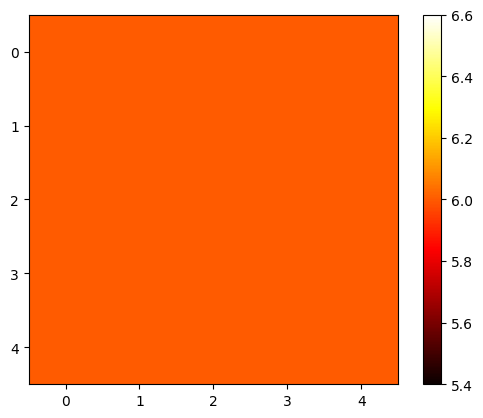

In [49]:
plt.imshow(test.cpu(), cmap='hot')
plt.colorbar() 
plt.show()

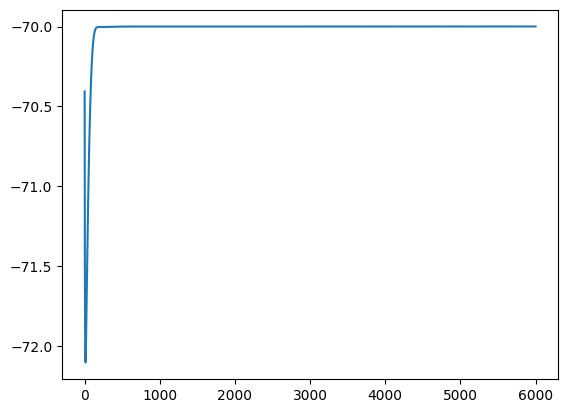

In [164]:
plt.plot(np.arange(pointCount), voltages)